## RAG chatbot powered by 🔗 Langchain, OpenAI, Google Generative AI and Hugging Face 🤗

In [1]:
import os
os.chdir("../")
%pwd

'c:\\Users\\Public\\Documents\\Project\\Document_Based_LLM_chatbot'

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os, tempfile, glob, random
from pathlib import Path
from IPython.display import Markdown
from PIL import Image
from getpass import getpass
import numpy as np
from itertools import combinations
from dotenv import load_dotenv


###  LLM: openai and google_genai

In [1]:
import openai
from langchain_openai import OpenAI, OpenAIEmbeddings, ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

c:\Users\abhis\anaconda3\envs\jeevini\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
a=

### LLM: HuggingFace

In [4]:

from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings
from langchain_community.llms import HuggingFaceHub

### langchain prompts, memory, chains...

In [5]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.chains import ConversationalRetrievalChain
from langchain_community.chat_message_histories import StreamlitChatMessageHistory
from operator import itemgetter
from langchain.memory import ConversationBufferMemory
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnablePassthrough
from langchain.schema import Document, format_document
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string

### Document loaders

In [6]:
from langchain_community.document_loaders import (
    PyPDFLoader,
    TextLoader,
    DirectoryLoader,
    CSVLoader,
    UnstructuredExcelLoader,
    Docx2txtLoader,
)

### Text Splitter

In [7]:
# Text Splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter


### OutputParser

In [8]:
from langchain_core.output_parsers import StrOutputParser

### Chroma: vectorstore

In [9]:
from langchain_community.vectorstores import Chroma

### Contextual Compression

In [10]:
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_transformers import EmbeddingsRedundantFilter,LongContextReorder
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers import ContextualCompressionRetriever

### Cohere

In [11]:
from langchain.retrievers.document_compressors import CohereRerank
from langchain_community.llms import Cohere

In [12]:
# Data Directories: where temp files and vectorstores will be saved

temp_dir = Path("./Data").resolve().parent.joinpath("Data", "tmp")
vector_store_dir = Path("./data").resolve().parent.joinpath("Data", "vector_stores")

### Load environment variables

In [13]:
def load_environment_variable(key):
    if key in os.environ:
        value = os.environ.get(key)
        print(f"\n[INFO]: {key} retrieved successfully.")
    else :
        print(f"\n[ERROR]: {key} is not found in your environment variables.") 
        value = getpass(f"Insert your {key}")
    return value

openai_api_key = load_environment_variable("OPENAI_API_KEY")
google_api_key = load_environment_variable("GOOGLE_API_KEY")
HF_key= load_environment_variable("HUGGINGFACEHUB_API_TOKEN") 
cohere_api_key=load_environment_variable("COHERE_API_KEY")


[INFO]: OPENAI_API_KEY retrieved successfully.

[INFO]: GOOGLE_API_KEY retrieved successfully.

[INFO]: HUGGINGFACEHUB_API_TOKEN retrieved successfully.


### RAG Architecture --------------------------------

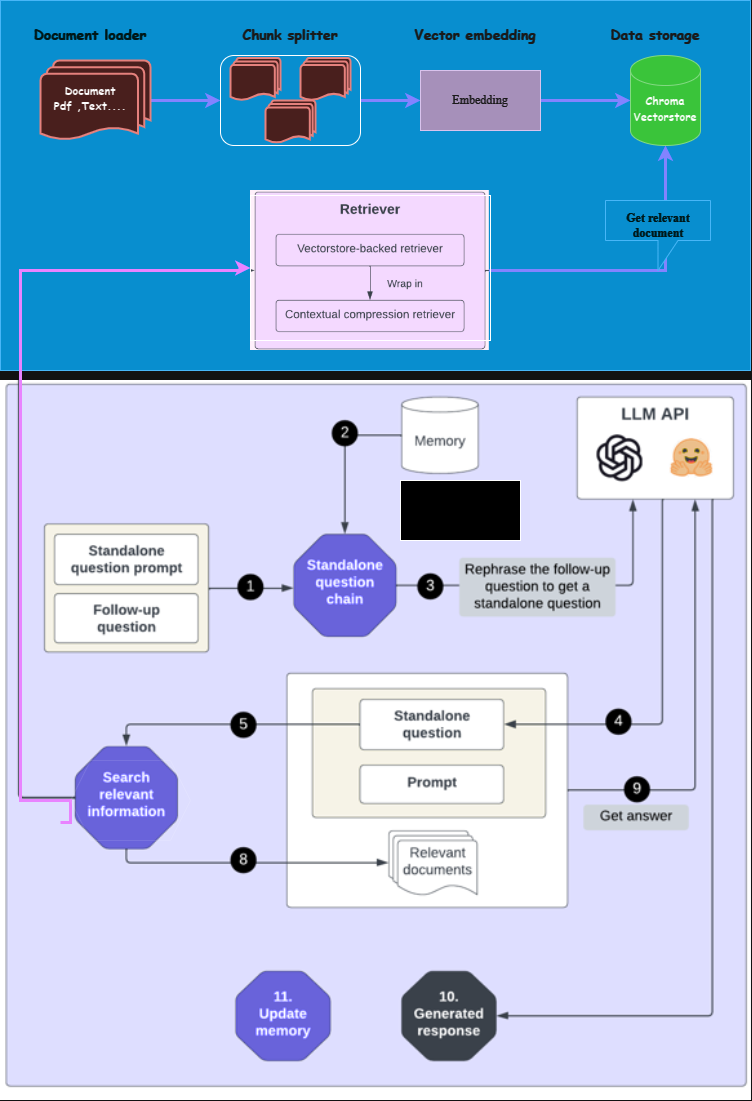

In [14]:
image=Image.open("./Data/docs/RAG Architecture.png")
display(image)

In [15]:

def langchain_document_loader(TMP_DIR):
    """
    Load files from TMP_DIR (temporary directory) as documents. Files can be in txt, pdf, CSV or docx format.
    """

    documents = []

    txt_loader = DirectoryLoader(
        TMP_DIR.as_posix(), glob="**/*.txt", loader_cls=TextLoader, show_progress=True
    )
    documents.extend(txt_loader.load())

    pdf_loader = DirectoryLoader(
        TMP_DIR.as_posix(), glob="**/*.pdf", loader_cls=PyPDFLoader, show_progress=True
    )
    documents.extend(pdf_loader.load())

    csv_loader = DirectoryLoader(
        TMP_DIR.as_posix(), glob="**/*.csv", loader_cls=CSVLoader, show_progress=True,
        loader_kwargs={"encoding":"utf8"}
    )
    documents.extend(csv_loader.load())

    doc_loader = DirectoryLoader(
        TMP_DIR.as_posix(),
        glob="**/*.docx",
        loader_cls=Docx2txtLoader,
        show_progress=True,
    )
    documents.extend(doc_loader.load())
    return documents

### Load documents

In [40]:
documents = langchain_document_loader(temp_dir)
print(f"\nNumber of documents: {len(documents)}")

[2024-04-29 14:57:04,032: INFO: helper: yaml file: config\config.yaml loaded successfully]


100%|██████████| 1/1 [00:14<00:00, 14.02s/it]

<class 'list'>

Number of documents: 1208


### Display a random document

In [17]:
import random
random_document_id = random.choice(range(len(documents)))

Markdown(f"**Document[{random_document_id}]** \n\n **Page content** (first 500 character):\n\n" +\
         documents[random_document_id].page_content[:500] + " ..."  +\
         "\n\n**Metadata:**\n\n" + str(documents[random_document_id].metadata))

**Document[727]** 

 **Page content** (first 500 character):

Chromium 
UNIVER SITY OF HA WAI‘I A T MĀNOA FOOD SCIENCE AND HUMAN 
NUTRITION PR OGRAM AND HUMAN NUTRITION PR OGRAM 
The func tioning o f chr omium in the bod y is less understood than 
that of most other miner als. I t enhanc es the ac tions o f insulin so i t 
plays a r ole in c arboh ydrate, fa t, and pr otein me tabolism. Curr ently, 
the r esults o f scien tific studies e valuating the usefulness o f 
chromium supplemen tation in pr eventing and tr eating Type 2 
diabe tes ar e lar gely inc ...

**Metadata:**

{'source': 'C:\\Users\\Public\\Documents\\Project\\Document_Based_LLM_chatbot\\Data\\tmp\\human-nutrition-text.pdf', 'page': 727}

### Text Splitter in to chunks

In [18]:
# Create a RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    #separators = ["\n\n", "\n", " ", ""],    
    chunk_size = 1200,
    chunk_overlap= 200,
    length_function=len
)

# Text splitting
chunks = text_splitter.split_documents(documents=documents)
print(f"number of chunks: {len(chunks)}")

number of chunks: 1865


In [19]:
chunks[500]

Document(page_content='mainl y found in f oods c ontaining fa t. Some fa t-soluble vi tamins \n(such as vi tamin A) ar e also f ound in na turally fat-free foods such \nas gr een le afy vegetables, c arrots, and br occoli. These vi tamins ar e \nbest absorbe d when c ombine d wi th foods c ontaining fa t. Fa ts also \nincrease the bioa vailabili ty of compounds kno wn as ph ytochemic als, \nwhich ar e plan t consti tuen ts such as l ycopene ( found in toma toes) \nand be ta-carotene ( found in c arrots). Phytochemic als ar e belie ved \nto pr omote he alth and w ell-being. As a r esult, e ating toma toes wi th \nolive oil or salad dr essing will facili tate lycopene absorption. Other \nessen tial nutrien ts, such as essen tial fa tty acids, ar e consti tuen ts of \nthe fa ts themsel ves and ser ve as building blocks o f a cell. \nFigur e 5.2 Food Sour ces of Omega 3’ s \n298  |  The Func tions o f Lipids in the Bod y', metadata={'source': 'C:\\Users\\Public\\Documents\\Project\\Documen

In [20]:
import tiktoken
def tokens_count(documents,model="gpt-3.5-turbo"):
    """Use tiktoken (tokeniser for OpenAI models) to return a list of token lengths per document."""    
    encoding = tiktoken.encoding_for_model(model) # returns the encoding used by the model.
    
    tokens_length = [len(encoding.encode(documents[i].page_content)) for i in range(len(documents))]

    return tokens_length
chunks_length = tokens_count(chunks,model="gpt-3.5-turbo")

print(f"Number of tokens - Average : {int(np.mean(chunks_length))}")
print(f"Number of tokens - 25% percentile : {int(np.quantile(chunks_length,0.25))}")
print(f"Number of tokens - 50% percentile : {int(np.quantile(chunks_length,0.5))}")
print(f"Number of tokens - 75% percentile : {int(np.quantile(chunks_length,0.75))}")
print("\nMax_tokens for gpt-3.5-turbo: 4096")

Number of tokens - Average : 275
Number of tokens - 25% percentile : 196
Number of tokens - 50% percentile : 312
Number of tokens - 75% percentile : 362

Max_tokens for gpt-3.5-turbo: 4096


### TEXT embeddings

In [21]:
def embedding_model_selection(LLM_service="OpenAI"):
    """Connect to the embeddings API endpoint by specifying the name of the embedding model."""
    if LLM_service == "OpenAI":
        embeddings = OpenAIEmbeddings(
            model='text-embedding-ada-002',
            api_key=openai_api_key)

    if LLM_service == "Google":
        embeddings = GoogleGenerativeAIEmbeddings(
            model="models/embedding-001",
            google_api_key=google_api_key
        )
    if LLM_service == "HuggingFace":
        embeddings = HuggingFaceInferenceAPIEmbeddings(    
            api_key=HF_key, 
            model_name="thenlper/gte-large"
        )
         
    return embeddings
   
embeddings_OpenAI = embedding_model_selection(LLM_service="OpenAI")
embeddings_google = embedding_model_selection(LLM_service="Google")
embeddings_HuggingFace = embedding_model_selection(LLM_service="HuggingFace")

In [22]:
sentences = ['display visitors count badge',
             'display github trophy',
             'display github profile stats card',
             'display top skills',
             'display twitter badge']
embedding_vectors = [embeddings_HuggingFace.embed_query(sentence) for sentence in sentences]

### Creating vectorstores

In [23]:
def vectorstore_creation(embeddings,documents,vectorstore_name):
    """Create a Chroma vector database."""
    persist_directory = (vector_store_dir.as_posix() + "/" + vectorstore_name)
    vector_store = Chroma.from_documents(
        documents=documents,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    return vector_store

In [24]:
%%time

create_vectorstores = True # change to True to create vectorstores

if create_vectorstores:
    
    vector_store_OpenAI,_ = vectorstore_creation(
        embeddings=embeddings_OpenAI,
        documents = chunks,
        vectorstore_name="Vit_All_OpenAI_Embeddings",
    )
    
    print("vector_store_OpenAI:",vector_store_OpenAI._collection.count(),"chunks.")
    
    vector_store_google = vectorstore_creation(
        embeddings=embeddings_google,
        documents = chunks,
        vectorstore_name="Vit_All_Google_Embeddings"
    )
    
    print("vector_store_google:",vector_store_google._collection.count(),"chunks.")
    '''
    vector_store_HF = vectorstore_creation(
        embeddings=embeddings_HuggingFace,
        documents = chunks,
        vectorstore_name="Vit_All_HF_Embeddings"
    )
    vector_store_HF.persist()
    #print("vector_store_HF:",vector_store_HF._collection.count(),"chunks.")
    print("")
    '''

TypeError: cannot unpack non-iterable Chroma object

### Load chroma vectorstore

In [26]:
vector_store_OpenAI = Chroma(
    persist_directory = vector_store_dir.as_posix() + "/Vit_All_OpenAI_Embeddings",
    embedding_function=embeddings_OpenAI)
print("vector_store_OpenAI:",vector_store_OpenAI._collection.count(),"chunks.")

vector_store_OpenAI: 1865 chunks.


In [25]:
vector_store_google = Chroma(
    persist_directory = vector_store_dir.as_posix() + "/Vit_All_Google_Embeddings",
    embedding_function=embeddings_HuggingFace)
print("vector_store_google:",vector_store_google._collection.count(),"chunks.")

vector_store_google: 0 chunks.


### Similarity search 

In [31]:
def display_documents(docs,search_with_score=False):
    """helper function to print documents."""
    if search_with_score:
        # used for similarity_search_with_score
        print(
            f"\n{'-' * 100}\n".join(
                [f"Document {i+1}:\n\n" + doc[0].page_content +"\n\nscore:"+str(round(doc[-1],3))+"\n" 
                 for i, doc in enumerate(docs)]
            )
        )
    else:
        # used for similarity_search or max_marginal_relevance_search
        print(
            f"\n{'-' * 100}\n".join(
                [f"Document {i+1}:\n\n" + doc.page_content 
                 for i, doc in enumerate(docs)]
            )
        )  

In [29]:
# Here, we use Cosine Similarity. So a lower score is better.

query = 'The Functions of Lipids in the Body ? '
docs_withScores = vector_store_OpenAI.similarity_search_with_score(query,k=4)
display_documents(docs_withScores,search_with_score=True)

[(Document(page_content='The Functions of Lipids in \nthe Body \nUNIVER SITY OF HA WAI‘I A T MĀNOA FOOD SCIENCE AND HUMAN \nNUTRITION PR OGRAM AND HUMAN NUTRITION PR OGRAM \nStoring Ener gy \nThe e xcess ener gy fr om the f ood w e eat is digeste d and \nincorpor ated into adipose tissue, or fa tty tissue. M ost o f the ener gy \nrequired by the human bod y is pr ovided by carboh ydrates and \nlipids. As discusse d in the Carboh ydrates chapter , glucose is stor ed \nin the bod y as g lycogen. W hile g lycogen pr ovides a r eady sour ce of \nener gy, lipids primaril y func tion as an ener gy reser ve. As y ou ma y \nrecall, g lycogen is qui te bulky wi th he avy w ater c ontent, thus the \nbody cannot stor e too much f or long. Alterna tively, fats ar e pack ed \ntoge ther tig htly wi thout w ater and stor e far gr eater amoun ts of \nener gy in a r educed spac e. A fa t gram is densel y concentrated with \nener gy—it contains mor e than double the amoun t of ener gy than a \ngram o f 

### Maximum marginal relevance search (MMR) search

In [33]:
query = 'What Makes Blood Healthy? '
docs_MMR = vector_store_OpenAI.max_marginal_relevance_search(query,k=4)

display_documents(docs_MMR)

Document 1:

into the blood, which tr anspor ts it to the br ain. Concurr ently, blood 
transpor ts oxygen to suppor t the me tabolism o f glucose to pr ovide 
ener gy in the br ain. H ealthy blood c onduc ts its duties r apidl y, 
avoiding h ypog lycemic c oma and de ath. This is just one e xample o f 
the bod y’s sur vival me chanisms e xemplif ying lif e’s man tra “All for 
one, one f or all. ” 
What Mak es Blood He althy? 
Main taining he althy blood, including i ts c ontinuous r enewal, is 
essen tial to suppor t its vast arr ay of vital func tions. B lood is he althy 
when i t contains the appr opria te amoun t of water and c ellular 
componen ts and pr oper c oncentrations o f dissol ved substanc es, 
such as al bumin and ele ctrolytes. As wi th all other tissues, blood 
needs macr o- and micr onutrien ts to optimall y func tion. I n the bone 
marr ow, wher e blood c ells ar e made, amino acids ar e required to 
build the massiv e amoun t of hemog lobin pack ed wi thin e very re

### Retrivers
<p1>A retriever is responsible for returning relevant documents to a query</p1>

In [ ]:
def Vectorstore_backed_retriever(vectorstore,search_type="similarity",k=4,score_threshold=None):
    """create a vectorsore-backed retriever
    Parameters: 
        search_type: Defines the type of search that the Retriever should perform.
            Can be "similarity" (default), "mmr", or "similarity_score_threshold"
        k: number of documents to return (Default: 4) 
        score_threshold: Minimum relevance threshold for similarity_score_threshold (default=None)
    """
    search_kwargs={}
    if k is not None:
        search_kwargs['k'] = k
    if score_threshold is not None:
        search_kwargs['score_threshold'] = score_threshold

    retriever = vectorstore.as_retriever(
        search_type=search_type,
        search_kwargs=search_kwargs
    )
    return retriever